# Model Notebook

In [1]:
import pandas as pd
import pandas.tseries
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import seaborn as sns
import statsmodels.api as sm

# Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller
# Auto Correlation
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
# AR Autoregressive
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings

import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima.arima.stationarity import ADFTest
from pmdarima.model_selection import train_test_split

from help_functions import *

warnings.filterwarnings('ignore')

In [2]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['Zipcode', 'RegionID', 'SizeRank', 'City', 
                                  'State', 'Metro', 'Borough'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

def melt_data_mean(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 
                                  'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})


def melt_data_roi(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 
                                  'State', 'Metro', 'CountyName', 'ROI'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted


def plot_trend(data, title):
    data.plot.line(color = 'green')
    plt.title(title)
    plt.ylabel('Price ($ in Thousands)')
    plt.grid()
    plt.show()
    
def plot_mean(x, y, xlabel, ylabel, title):
    plt.figure(figsize=(8,6))
    sns.barplot(x,y, palette = 'Blues_d')
    plt.xlabel(f'{xlabel}')
    plt.ylabel(f'{ylabel}')
    plt.grid()
    plt.title(f'{title} in New York City')

    
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

# matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [3]:
df = pd.read_csv('zillow_data.csv')
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


In [4]:
# Filter City column to just New York
nyc = df[df['City'] == 'New York']
nyc

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
6,61807,10467,New York,NY,New York,Bronx,7,152900.0,152700.0,152600.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
10,62037,11226,New York,NY,New York,Kings,11,162000.0,162300.0,162600.0,...,860200,851000,853900,870000,885100,887800,890500,901700,930700,963200
12,62087,11375,New York,NY,New York,Queens,13,252400.0,251800.0,251400.0,...,1022600,1033700,1048600,1066400,1081200,1088800,1092700,1089500,1084000,1084600
13,62045,11235,New York,NY,New York,Kings,14,190500.0,191000.0,191500.0,...,767300,777300,788800,793900,796000,799700,806600,810600,813400,816200
20,61625,10011,New York,NY,New York,New York,21,NaN,NaN,NaN,...,12137600,12112600,12036600,12050100,12016300,11946500,11978100,11849300,11563000,11478300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8008,62122,11436,New York,NY,New York,Queens,8009,119000.0,119400.0,119900.0,...,383800,382200,381000,382500,385600,387600,388700,390600,395100,400300
8303,62078,11366,New York,NY,New York,Queens,8304,231800.0,232000.0,232300.0,...,830000,839100,847800,854900,859600,861700,865600,871900,882700,893600
8387,61783,10307,New York,NY,New York,Richmond,8388,186700.0,186800.0,186900.0,...,522000,525600,527900,533800,543300,550800,559300,566900,571600,575900
9911,62075,11363,New York,NY,New York,Queens,9912,295000.0,296200.0,297700.0,...,1032000,1043700,1049800,1047900,1041200,1035400,1040700,1048600,1052100,1051300


In [5]:
# Rename RegionName and County columns to Zip code and Borough
nyc = nyc.rename({'RegionName':'Zipcode'}, axis = 'columns')
nyc = nyc.rename({'CountyName':'Borough'}, axis = 'columns')

In [6]:
nyc['Borough'].replace({'Kings': 'Brooklyn', 'Richmond': 'Staten Island', 'New York': 'Manhattan'}, inplace = True)

In [7]:
nyc

,RegionID,Zipcode,City,State,Metro,Borough,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
6,61807,10467,New York,NY,New York,Bronx,7,152900.0,152700.0,152600.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
10,62037,11226,New York,NY,New York,Brooklyn,11,162000.0,162300.0,162600.0,...,860200,851000,853900,870000,885100,887800,890500,901700,930700,963200
12,62087,11375,New York,NY,New York,Queens,13,252400.0,251800.0,251400.0,...,1022600,1033700,1048600,1066400,1081200,1088800,1092700,1089500,1084000,1084600
13,62045,11235,New York,NY,New York,Brooklyn,14,190500.0,191000.0,191500.0,...,767300,777300,788800,793900,796000,799700,806600,810600,813400,816200
20,61625,10011,New York,NY,New York,Manhattan,21,NaN,NaN,NaN,...,12137600,12112600,12036600,12050100,12016300,11946500,11978100,11849300,11563000,11478300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8008,62122,11436,New York,NY,New York,Queens,8009,119000.0,119400.0,119900.0,...,383800,382200,381000,382500,385600,387600,388700,390600,395100,400300
8303,62078,11366,New York,NY,New York,Queens,8304,231800.0,232000.0,232300.0,...,830000,839100,847800,854900,859600,861700,865600,871900,882700,893600
8387,61783,10307,New York,NY,New York,Staten Island,8388,186700.0,186800.0,186900.0,...,522000,525600,527900,533800,543300,550800,559300,566900,571600,575900
9911,62075,11363,New York,NY,New York,Queens,9912,295000.0,296200.0,297700.0,...,1032000,1043700,1049800,1047900,1041200,1035400,1040700,1048600,1052100,1051300


In [8]:
zip_lst = list(nyc['Zipcode'].values)
len(zip_lst)

114

There are 114 zip codes provided for NYC

In [9]:
nyc['Zipcode'].unique

<bound method Series.unique of 6        10467
10       11226
12       11375
13       11235
20       10011
         ...  
8008     11436
8303     11366
8387     10307
9911     11363
11037    10464
Name: Zipcode, Length: 114, dtype: int64>

In [10]:
# Melt the data
nyc_melt = melt_data(nyc)
nyc_melt

,Zipcode,RegionID,SizeRank,City,State,Metro,Borough,time,value
0,10467,61807,7,New York,NY,New York,Bronx,1996-04-01,152900.0
1,11226,62037,11,New York,NY,New York,Brooklyn,1996-04-01,162000.0
2,11375,62087,13,New York,NY,New York,Queens,1996-04-01,252400.0
3,11235,62045,14,New York,NY,New York,Brooklyn,1996-04-01,190500.0
5,10128,61703,22,New York,NY,New York,Manhattan,1996-04-01,3676700.0
...,...,...,...,...,...,...,...,...,...
30205,11436,62122,8009,New York,NY,New York,Queens,2018-04-01,400300.0
30206,11366,62078,8304,New York,NY,New York,Queens,2018-04-01,893600.0
30207,10307,61783,8388,New York,NY,New York,Staten Island,2018-04-01,575900.0
30208,11363,62075,9912,New York,NY,New York,Queens,2018-04-01,1051300.0


In [11]:
nyc_melt[nyc_melt['Zipcode'] == 10456]

,Zipcode,RegionID,SizeRank,City,State,Metro,Borough,time,value
24289,10456,61796,37,New York,NY,New York,Bronx,2014-01-01,274300.0
24403,10456,61796,37,New York,NY,New York,Bronx,2014-02-01,274000.0
24517,10456,61796,37,New York,NY,New York,Bronx,2014-03-01,276700.0
24631,10456,61796,37,New York,NY,New York,Bronx,2014-04-01,280100.0
24745,10456,61796,37,New York,NY,New York,Bronx,2014-05-01,278600.0
24859,10456,61796,37,New York,NY,New York,Bronx,2014-06-01,274000.0
24973,10456,61796,37,New York,NY,New York,Bronx,2014-07-01,269700.0
25087,10456,61796,37,New York,NY,New York,Bronx,2014-08-01,267800.0
25201,10456,61796,37,New York,NY,New York,Bronx,2014-09-01,267700.0
25315,10456,61796,37,New York,NY,New York,Bronx,2014-10-01,271400.0


In [12]:
zip_lst = list(nyc_melt['Zipcode'].values)
zip_lst

[10467,
 11226,
 11375,
 11235,
 10128,
 10462,
 10463,
 11230,
 11209,
 11212,
 11214,
 11221,
 11229,
 11377,
 11234,
 11355,
 10314,
 11215,
 11211,
 11385,
 11373,
 11233,
 11236,
 11372,
 11218,
 11223,
 11208,
 11204,
 11219,
 11368,
 11203,
 11220,
 11216,
 11354,
 10466,
 11374,
 10473,
 11210,
 11434,
 11224,
 10306,
 11691,
 10469,
 10312,
 10461,
 11106,
 11432,
 11222,
 11435,
 11365,
 11103,
 11367,
 11102,
 10304,
 10301,
 11357,
 10305,
 11105,
 10465,
 11364,
 11358,
 11104,
 11228,
 11379,
 11413,
 11420,
 11414,
 10309,
 11361,
 11412,
 10471,
 11378,
 11421,
 11419,
 11433,
 11360,
 10308,
 11415,
 11418,
 11423,
 11369,
 10310,
 10303,
 11422,
 11694,
 11417,
 11427,
 11692,
 11370,
 11356,
 11429,
 11362,
 11411,
 10470,
 11426,
 10302,
 11428,
 11004,
 11416,
 11436,
 11366,
 10307,
 11363,
 10464,
 10467,
 11226,
 11375,
 11235,
 10128,
 10462,
 10463,
 11230,
 11209,
 11212,
 11214,
 11221,
 11229,
 11377,
 11234,
 11355,
 10314,
 11215,
 11211,
 11385,
 11373,


In [13]:
nyc_melt.set_index('time', inplace = True)

In [14]:
zip_dict = {}

for zipcode in zip_lst:
    x = nyc_melt.groupby('Zipcode').get_group(zipcode).sort_index()['value']
    zip_dict[zipcode] = x

In [15]:
ts_df = pd.DataFrame(zip_dict)
ts_df

,10467,11226,11375,11235,10128,10462,10463,11230,11209,11212,...,10459,11238,10021,10014,11205,11217,11231,10011,11101,10456
time,,,,,,,,,,,,,,,,,,,,,
1996-04-01,152900.0,162000.0,252400.0,190500.0,3676700.0,154300.0,180100.0,230100.0,255700.0,125000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-05-01,152700.0,162300.0,251800.0,191000.0,3704200.0,154300.0,181000.0,230800.0,256600.0,125000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-06-01,152600.0,162600.0,251400.0,191500.0,3729600.0,154400.0,181900.0,231500.0,257300.0,125000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-07-01,152400.0,163000.0,251200.0,192000.0,3754600.0,154400.0,182600.0,232100.0,258100.0,125000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-08-01,152300.0,163400.0,251100.0,192500.0,3781800.0,154500.0,183200.0,232800.0,258900.0,125100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,414300.0,887800.0,1088800.0,799700.0,7342700.0,443900.0,726900.0,1102400.0,1018900.0,414900.0,...,370100.0,2768900.0,18307100.0,9492800.0,2251000.0,3404100.0,2961600.0,11946500.0,742900.0,368500.0
2018-01-01,413900.0,890500.0,1092700.0,806600.0,7353300.0,446000.0,744500.0,1120200.0,1023500.0,422300.0,...,383000.0,2810700.0,18365900.0,9524900.0,2251600.0,3413800.0,2965300.0,11978100.0,767300.0,374100.0
2018-02-01,411400.0,901700.0,1089500.0,810600.0,7350300.0,446400.0,757000.0,1141600.0,1029200.0,426300.0,...,393400.0,2848100.0,18530400.0,9373400.0,2245300.0,3482900.0,2974000.0,11849300.0,769700.0,379800.0


In [16]:
ts_final = ts_df[ts_df.index.year > 2009]
ts_final

,10467,11226,11375,11235,10128,10462,10463,11230,11209,11212,...,10459,11238,10021,10014,11205,11217,11231,10011,11101,10456
time,,,,,,,,,,,,,,,,,,,,,
2010-01-01,328100.0,531900.0,679200.0,507200.0,5983800.0,340900.0,581100.0,725000.0,724200.0,292200.0,...,282300.0,1196100.0,11762000.0,6011100.0,1383000.0,1544500.0,1295800.0,6785500.0,NaN,NaN
2010-02-01,327000.0,535900.0,680700.0,509500.0,6127100.0,339400.0,583200.0,724800.0,726600.0,292400.0,...,280900.0,1193400.0,11763400.0,6077600.0,1396200.0,1548800.0,1301900.0,6811100.0,NaN,NaN
2010-03-01,326000.0,525500.0,684400.0,508000.0,6202900.0,338400.0,577800.0,719900.0,715700.0,291700.0,...,280500.0,1183700.0,11863500.0,6091100.0,1354800.0,1547100.0,1289300.0,6722700.0,NaN,NaN
2010-04-01,326300.0,509900.0,688000.0,502700.0,5969400.0,337200.0,559600.0,712600.0,693200.0,290700.0,...,281700.0,1177800.0,12306900.0,5991100.0,1299200.0,1534700.0,1291600.0,6578200.0,NaN,NaN
2010-05-01,327300.0,502700.0,691300.0,501000.0,5825600.0,337400.0,543700.0,709800.0,679100.0,290800.0,...,280400.0,1168400.0,12780700.0,6018600.0,1287300.0,1531000.0,1317400.0,6555400.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,414300.0,887800.0,1088800.0,799700.0,7342700.0,443900.0,726900.0,1102400.0,1018900.0,414900.0,...,370100.0,2768900.0,18307100.0,9492800.0,2251000.0,3404100.0,2961600.0,11946500.0,742900.0,368500.0
2018-01-01,413900.0,890500.0,1092700.0,806600.0,7353300.0,446000.0,744500.0,1120200.0,1023500.0,422300.0,...,383000.0,2810700.0,18365900.0,9524900.0,2251600.0,3413800.0,2965300.0,11978100.0,767300.0,374100.0
2018-02-01,411400.0,901700.0,1089500.0,810600.0,7350300.0,446400.0,757000.0,1141600.0,1029200.0,426300.0,...,393400.0,2848100.0,18530400.0,9373400.0,2245300.0,3482900.0,2974000.0,11849300.0,769700.0,379800.0


In [17]:
ts_final.isna().sum().sum()

72

There are 12 missing values in our data. Below we will look which data is missing

In [18]:
ts_final[ts_final[10456].isna()]

,10467,11226,11375,11235,10128,10462,10463,11230,11209,11212,...,10459,11238,10021,10014,11205,11217,11231,10011,11101,10456
time,,,,,,,,,,,,,,,,,,,,,
2010-01-01,328100.0,531900.0,679200.0,507200.0,5983800.0,340900.0,581100.0,725000.0,724200.0,292200.0,...,282300.0,1196100.0,11762000.0,6011100.0,1383000.0,1544500.0,1295800.0,6785500.0,NaN,NaN
2010-02-01,327000.0,535900.0,680700.0,509500.0,6127100.0,339400.0,583200.0,724800.0,726600.0,292400.0,...,280900.0,1193400.0,11763400.0,6077600.0,1396200.0,1548800.0,1301900.0,6811100.0,NaN,NaN
2010-03-01,326000.0,525500.0,684400.0,508000.0,6202900.0,338400.0,577800.0,719900.0,715700.0,291700.0,...,280500.0,1183700.0,11863500.0,6091100.0,1354800.0,1547100.0,1289300.0,6722700.0,NaN,NaN
2010-04-01,326300.0,509900.0,688000.0,502700.0,5969400.0,337200.0,559600.0,712600.0,693200.0,290700.0,...,281700.0,1177800.0,12306900.0,5991100.0,1299200.0,1534700.0,1291600.0,6578200.0,NaN,NaN
2010-05-01,327300.0,502700.0,691300.0,501000.0,5825600.0,337400.0,543700.0,709800.0,679100.0,290800.0,...,280400.0,1168400.0,12780700.0,6018600.0,1287300.0,1531000.0,1317400.0,6555400.0,NaN,NaN
2010-06-01,330100.0,504900.0,695800.0,507600.0,5883200.0,340100.0,540600.0,719100.0,682700.0,292800.0,...,279600.0,1166700.0,13091400.0,6157400.0,1307800.0,1549200.0,1340200.0,6647400.0,NaN,NaN
2010-07-01,334100.0,499100.0,703500.0,512800.0,5925500.0,342800.0,538700.0,724000.0,682000.0,295200.0,...,283500.0,1168200.0,13320400.0,6240200.0,1318800.0,1567300.0,1358000.0,6725000.0,NaN,NaN
2010-08-01,335000.0,491300.0,700800.0,511100.0,5880800.0,344900.0,527500.0,718600.0,675800.0,297100.0,...,286600.0,1162900.0,13445900.0,6217900.0,1296600.0,1559000.0,1347300.0,6783400.0,NaN,NaN
2010-09-01,333200.0,479400.0,690600.0,506600.0,5769600.0,345200.0,513600.0,706600.0,670100.0,297800.0,...,286400.0,1152900.0,13485100.0,6195400.0,1258500.0,1535500.0,1317600.0,6789200.0,NaN,NaN


In [19]:
# back fill for all the missing data in zip code #10456
ts_final.bfill(inplace = True)

In [20]:
ts_final

,10467,11226,11375,11235,10128,10462,10463,11230,11209,11212,...,10459,11238,10021,10014,11205,11217,11231,10011,11101,10456
time,,,,,,,,,,,,,,,,,,,,,
2010-01-01,328100.0,531900.0,679200.0,507200.0,5983800.0,340900.0,581100.0,725000.0,724200.0,292200.0,...,282300.0,1196100.0,11762000.0,6011100.0,1383000.0,1544500.0,1295800.0,6785500.0,444300.0,274300.0
2010-02-01,327000.0,535900.0,680700.0,509500.0,6127100.0,339400.0,583200.0,724800.0,726600.0,292400.0,...,280900.0,1193400.0,11763400.0,6077600.0,1396200.0,1548800.0,1301900.0,6811100.0,444300.0,274300.0
2010-03-01,326000.0,525500.0,684400.0,508000.0,6202900.0,338400.0,577800.0,719900.0,715700.0,291700.0,...,280500.0,1183700.0,11863500.0,6091100.0,1354800.0,1547100.0,1289300.0,6722700.0,444300.0,274300.0
2010-04-01,326300.0,509900.0,688000.0,502700.0,5969400.0,337200.0,559600.0,712600.0,693200.0,290700.0,...,281700.0,1177800.0,12306900.0,5991100.0,1299200.0,1534700.0,1291600.0,6578200.0,444300.0,274300.0
2010-05-01,327300.0,502700.0,691300.0,501000.0,5825600.0,337400.0,543700.0,709800.0,679100.0,290800.0,...,280400.0,1168400.0,12780700.0,6018600.0,1287300.0,1531000.0,1317400.0,6555400.0,444300.0,274300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,414300.0,887800.0,1088800.0,799700.0,7342700.0,443900.0,726900.0,1102400.0,1018900.0,414900.0,...,370100.0,2768900.0,18307100.0,9492800.0,2251000.0,3404100.0,2961600.0,11946500.0,742900.0,368500.0
2018-01-01,413900.0,890500.0,1092700.0,806600.0,7353300.0,446000.0,744500.0,1120200.0,1023500.0,422300.0,...,383000.0,2810700.0,18365900.0,9524900.0,2251600.0,3413800.0,2965300.0,11978100.0,767300.0,374100.0
2018-02-01,411400.0,901700.0,1089500.0,810600.0,7350300.0,446400.0,757000.0,1141600.0,1029200.0,426300.0,...,393400.0,2848100.0,18530400.0,9373400.0,2245300.0,3482900.0,2974000.0,11849300.0,769700.0,379800.0


## Modeling Testing

In [21]:
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate difference
    difference = TS.diff().dropna()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS.diff().dropna())
    
    # Plot Difference:
    fig = plt.figure(figsize=(12,6))
    plt.plot(difference, color='red', label='Difference in Lag')
    plt.legend(loc='best')
    plt.title('Difference in Lag')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.DataFrame(dftest[0:4], index=['Test Statistic',
                                            'p-value','#Lags Used','Number of Observations Used'], columns = ['Results'])
    print(dfoutput)
    
    return None

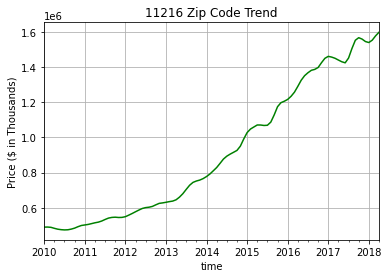

In [22]:
# look for trend
plot_trend(ts_final[11216], '11216 Zip Code Trend')

Here we are looking at the overall movement for zip code 11216.

## Stationarity Check & Removing Trends

Checking for stationary in our data. Since we have a trend in our data, we need to remove it in order to pass our data into our models. Removing stationarity will help remove all the noisy components in our data. The way we check for stationarity is using the Dickey-Fuller Test. If the p-value is less than .05 then it passes the stationarity check.

To choose which way we will be removing trends is by:

- Taking the log transformation
- Subtracting the rolling mean
- Differencing (subtracting the previous value to the current value)

We will compare all p-values to see which is the most efficient way of removing trends

In [23]:
# dickey fuller test 1
test1 = adfuller(ts_final[11216])
pd.DataFrame(test1[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'], columns = ['Results'])

,Results
Test Statistic,0.129346
p-value,0.968008
#Lags Used,9.000000
Number of Observations Used,90.000000


In [24]:
# difference from lag
difference = adfuller(ts_final[11216].diff().dropna())
pd.DataFrame(difference[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'], columns = ['Results'])

,Results
Test Statistic,-2.196588
p-value,0.207486
#Lags Used,8.000000
Number of Observations Used,90.000000


In [25]:
# log transformation
log_transform = adfuller(np.log(ts_final[11216]))
pd.DataFrame(log_transform[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'], columns = ['Results'])

,Results
Test Statistic,-0.977856
p-value,0.761255
#Lags Used,9.000000
Number of Observations Used,90.000000


In [26]:
# difference from rolling mean
roll_mean = ts_final[11216].rolling(window=12).mean()
mean_diff = ts_final[11216] - roll_mean
mean_diff.dropna(inplace=True)
results = adfuller(mean_diff)
pd.DataFrame(results[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'], columns = ['Results'])

,Results
Test Statistic,-1.449179
p-value,0.558485
#Lags Used,10.000000
Number of Observations Used,78.000000


In [27]:
final_results = test1[0:4], difference[0:4], log_transform[0:4], results[0:4]

In [28]:
pd.DataFrame(final_results, columns = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

,Test Statistic,p-value,#Lags Used,Number of Observations Used
0,0.129346,0.968008,9,90
1,-2.196588,0.207486,8,90
2,-0.977856,0.761255,9,90
3,-1.449179,0.558485,10,78


Based on our results, differencing has the lowest p-value. But our data is not stationary.

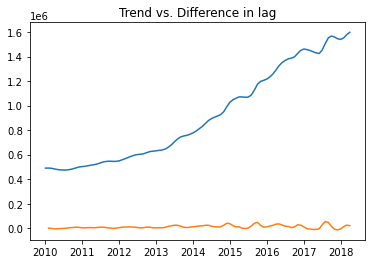

In [29]:
plt.title('Trend vs. Difference in lag')
plt.plot(ts_final[11216])
plt.plot(ts_final[11216].diff().dropna())
plt.show()

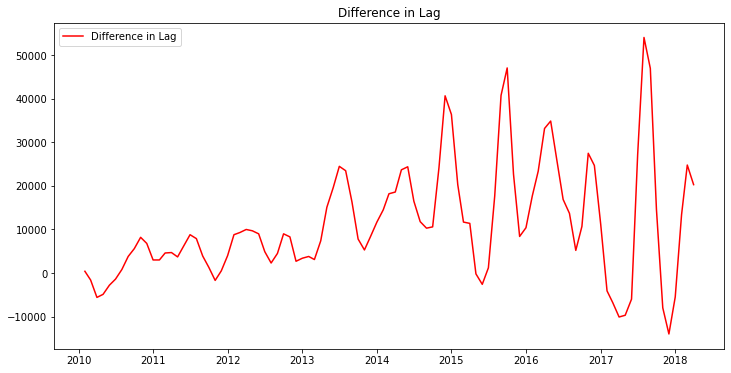

Results of Dickey-Fuller Test: 

                               Results
Test Statistic               -2.196588
p-value                       0.207486
#Lags Used                    8.000000
Number of Observations Used  90.000000


In [30]:
stationarity_check(ts_final[11216])

Observing for seasonality which will look for the consistent yearly pattern within the zip code 11216

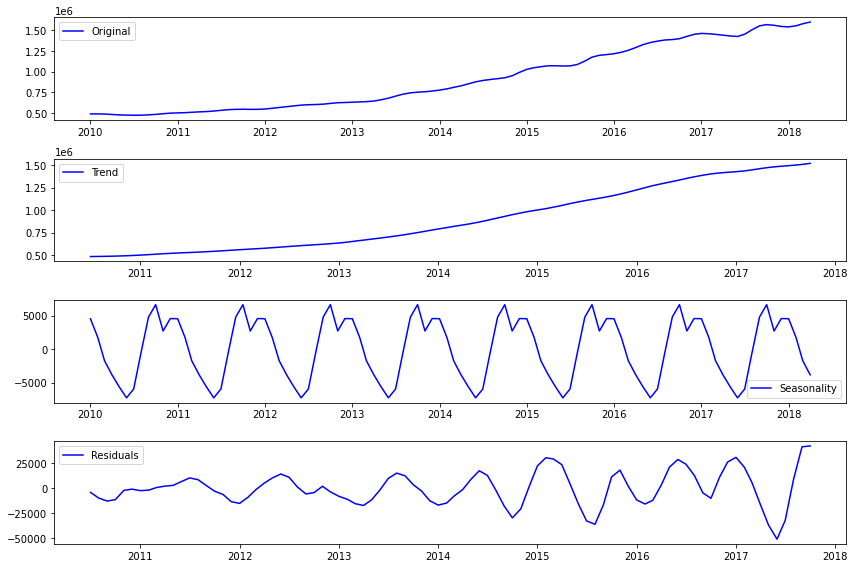

In [31]:
# looking at seasonality
decomposition = seasonal_decompose(ts_final[11216])

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(ts_final[11216], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()


## ACF & PACF

We are looking at the correlation between the data and the shifted data. This is used for our forecasting.

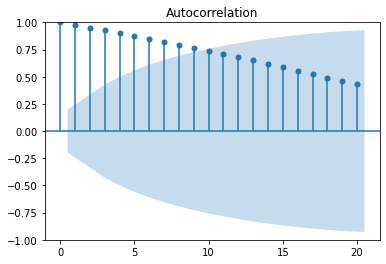

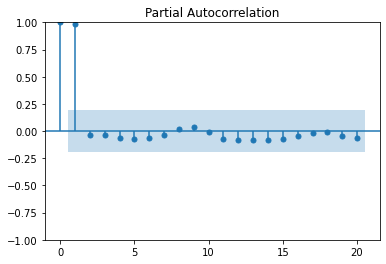

In [32]:
plot_acf(ts_final[11216][:-1], alpha=.05)
plt.show()

plot_pacf(ts_final[11216][:-1], alpha = .05)
plt.show()

**Note:**

ACF & PACF has two significant lag

# Testing Zip Code 11216

In [33]:
def get_model(model, df):
    
    # test-train-split by hand
    SPLIT = int(df.shape[0]*0.8)
    train, test = df[:'2017-03-01'], df['2017-03-01':]
    
    # fit model
    model().fit()
    
    # get model summary
    model.summary()
    
    return model

def plot_model(model, df, title, n):
    
    # get predictions
    trainpreds = model.predict()
    testpreds = model.forecast(n)
    
    # plot model predictions/forecast
    fig, ax = plt.subplots(figsize=(10,7))
    plt.plot(df)
    plt.plot(trainpreds[1:].append(testpreds), label='Predicted')
    plt.plot(testpreds, label = 'Forecast')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Price')
    plt.legend(['Original', 'Predicted', 'Forecast'], loc = 'lower right')
    plt.show()
    
def get_metrics(model, n):
    trainpreds = model.predict()
    testpreds = model.forecast(n)
    
    print('Train RMSE: ', mean_squared_error(train, trainpreds)**0.5)
    print('Test RMSE: ', mean_squared_error(test, testpreds)**0.5)

# fix
def model_iterations():
    p = q = (0,1,2)
    diff = 1

    combo, value = (None, None)
    for ar in p:
        for ma in q:
            try:
                model = ARIMA(train, order=(ar, diff, ma)).fit()
                print('Combo:', (ar, diff, ma),'AIC:', model.aic)

                if value is None or model.aic < value:
                    combo, value = ((ar, diff, ma), model.aic)
                    print(f'\tBest Parameters Updated')
            except ValueError:
                pass
            
    print(f'\n{"*"*20}\nOptimal SARIMAX order: {combo}')

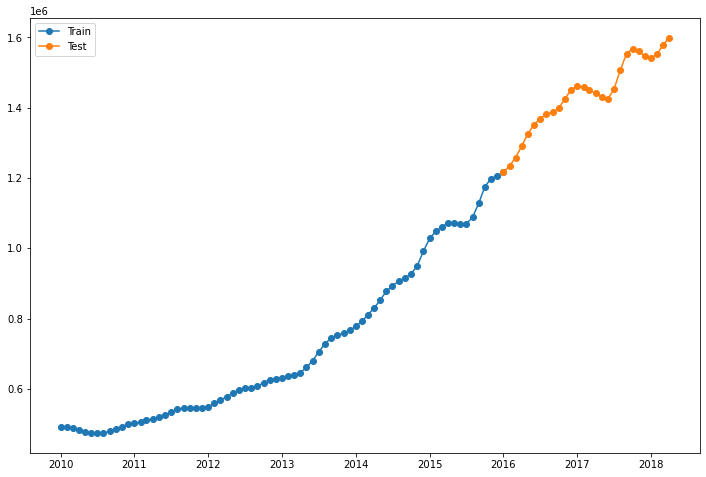

In [34]:
# test-train-split by hand
# train 2013 - 2017
# test 2017-2018



# Train - Test - Split
train = ts_final[11216][:'2016-01-01']
test = ts_final[11216]['2016-01-01':]

# Visualize split
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(train, label='Train', **kws)
plt.plot(test, label='Test', **kws)
ax.legend();

In [35]:
print(min(train.index))
print(min(test.index))

2010-01-01 00:00:00
2016-01-01 00:00:00


In [36]:
len(train)

73

In [37]:
len(test)

28

## Model Test 1 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11216   No. Observations:                   73
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -733.380
Date:                Wed, 09 Mar 2022   AIC                           1476.760
Time:                        13:36:23   BIC                           1488.073
Sample:                    01-01-2010   HQIC                          1481.259
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4461      0.440      3.284      0.001       0.583       2.309
ar.L2         -0.5232      0.389     -1.346      0.178      -1.285       0.239
ma.L1         -1.5565      0.456     -3.414      0.001      -2.450      -0.663
ma.L2          0.5565      0.448      1.243      0.214      -0.321       1.434
sigma2      2.068e+07   3.41e-08   6.07e+14      0.000    2.07e+07    2.07e+07
===================================================================================
Ljung-Box (L1) (Q):                  14.33   Jarque-Bera (JB):                35.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.21   Skew:                             0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.36e+30. Standard errors may be unstable.
"""

Train RMSE:  78753.42997833897
Test RMSE:  47717.792555706554
None


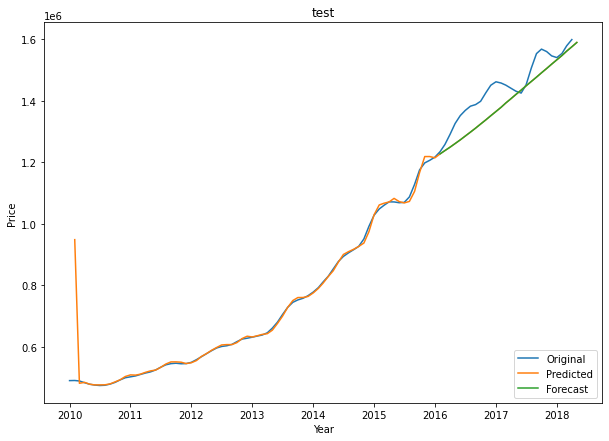

In [38]:
# order = (p, d, q)
# p - autoregressive
# d - differences
# q - moving average

ar1 = ARIMA(train, order=(2,2,2)).fit()
display(ar1.summary())
print(get_metrics(ar1, 28))
plot_model(ar1, ts_final[11216], 'test',28)

## Model Test 2

In [39]:
# provided by study group
# Iterating through p, d, q values.
# getting the optimal arima iterations
p = q = (0,1,2,3)
diff = 0

combo, value = (None, None)
for ar in p:
    for ma in q:
        try:
            model = ARIMA(train, order=(ar, diff, ma)).fit()
            print('Combo:', (ar, diff, ma),'AIC:', model.aic)

            if value is None or model.aic < value:
                combo, value = ((ar, diff, ma), model.aic)
                print(f'\tBest Parameters Updated')
        except ValueError:
            pass
            
print(f'\n{"*"*20}\nOptimal ARIMA order: {combo}')

Combo: (0, 0, 0) AIC: 2252.191397273479
	Best Parameters Updated
Combo: (0, 0, 1) AIC: 1961.9818725418081
	Best Parameters Updated
Combo: (0, 0, 2) AIC: 1951.033582049747
	Best Parameters Updated
Combo: (0, 0, 3) AIC: 1947.8026493646116
	Best Parameters Updated
Combo: (1, 0, 0) AIC: 1619.8866305756244
	Best Parameters Updated
Combo: (1, 0, 1) AIC: 1538.4402487179234
	Best Parameters Updated
Combo: (1, 0, 2) AIC: 1478.9632198513
	Best Parameters Updated
Combo: (1, 0, 3) AIC: 1467.0841543943995
	Best Parameters Updated
Combo: (2, 0, 0) AIC: 1507.5720626970785
Combo: (2, 0, 1) AIC: 1472.5782352560325
Combo: (2, 0, 2) AIC: 1461.1502882251762
	Best Parameters Updated
Combo: (2, 0, 3) AIC: 1477.246208643279
Combo: (3, 0, 0) AIC: 1577.3813497998242
Combo: (3, 0, 1) AIC: 1489.7260649487732
Combo: (3, 0, 2) AIC: 1456.8668800551823
	Best Parameters Updated
Combo: (3, 0, 3) AIC: 1447.890235125815
	Best Parameters Updated

********************
Optimal ARIMA order: (3, 0, 3)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11216   No. Observations:                   73
Model:                 ARIMA(3, 0, 3)   Log Likelihood                -715.945
Date:                Wed, 09 Mar 2022   AIC                           1447.890
Time:                        13:36:25   BIC                           1466.214
Sample:                    01-01-2010   HQIC                          1455.193
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.201e+05   1.59e-08   4.53e+13      0.000     7.2e+05     7.2e+05
ar.L1          2.0566      0.144     14.286      0.000       1.774       2.339
ar.L2         -1.1236      0.256     -4.385      0.000      -1.626      -0.621
ar.L3          0.0667      0.114      0.586      0.558      -0.156       0.290
ma.L1          0.7949      0.241      3.295      0.001       0.322       1.268
ma.L2         -0.5586      0.263     -2.126      0.034      -1.074      -0.044
ma.L3         -0.9126      0.140     -6.518      0.000      -1.187      -0.638
sigma2      1.584e+07   1.71e-08   9.29e+14      0.000    1.58e+07    1.58e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                40.69
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              14.33   Skew:                             0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.55e+32. Standard errors may be unstable.
"""

Train RMSE:  27186.406566669426
Test RMSE:  56550.3079466871
None


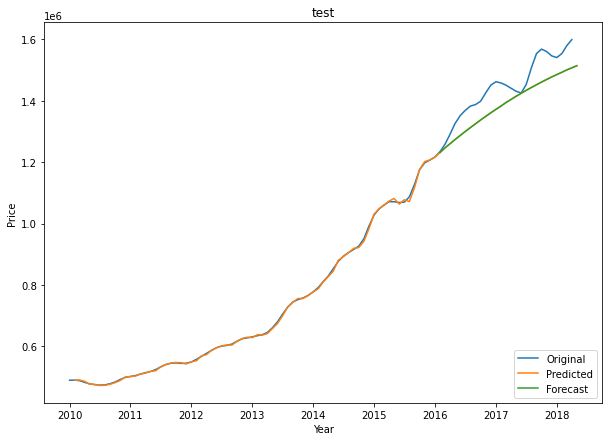

In [40]:
arima_op = ARIMA(train, order=(3,0,3)).fit()
display(arima_op.summary())
print(get_metrics(arima_op, 28))
plot_model(arima_op, ts_final[11216], 'test',28)

## Model Test 3 Auto Arima Chosen Model

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1587.365, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1737.683, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1591.992, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1542.826, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1561.154, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1557.133, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1543.581, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.353 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   73
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -769.413
Date:                Wed, 09 Mar 2022   AIC                           1542.826
Time:                        13:36:26   BIC                           1547.380
Sample:                             0   HQIC                          1544.639
                                 - 73                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.009e+04   1729.745      5.833      0.000    6700.039    1.35e+04
sigma2      1.121e+08   1.79e+07      6.246      0.000    7.69e+07    1.47e+08
===================================================================================
Ljung-Box (L1) (Q):                  47.08   Jarque-Bera (JB):                38.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.06   Skew:                             1.41
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

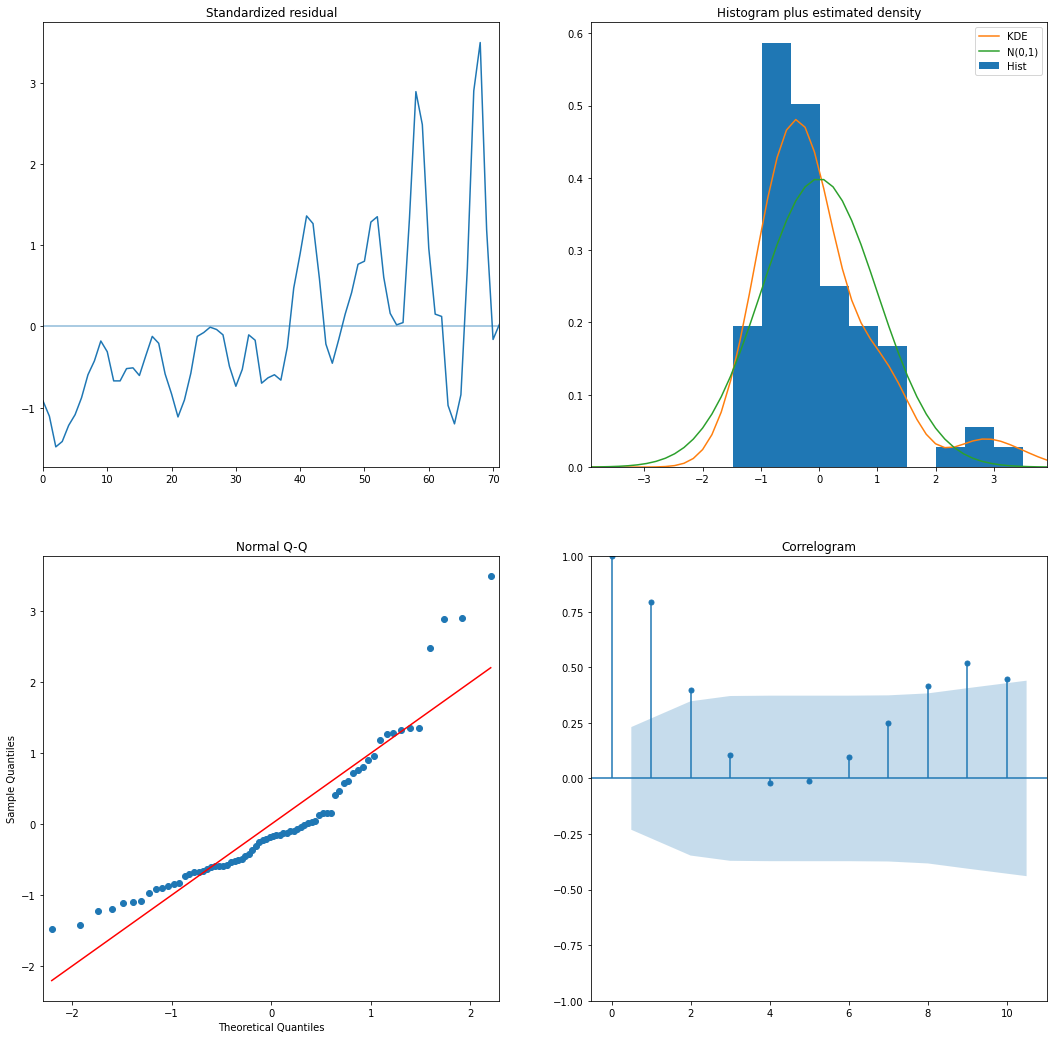

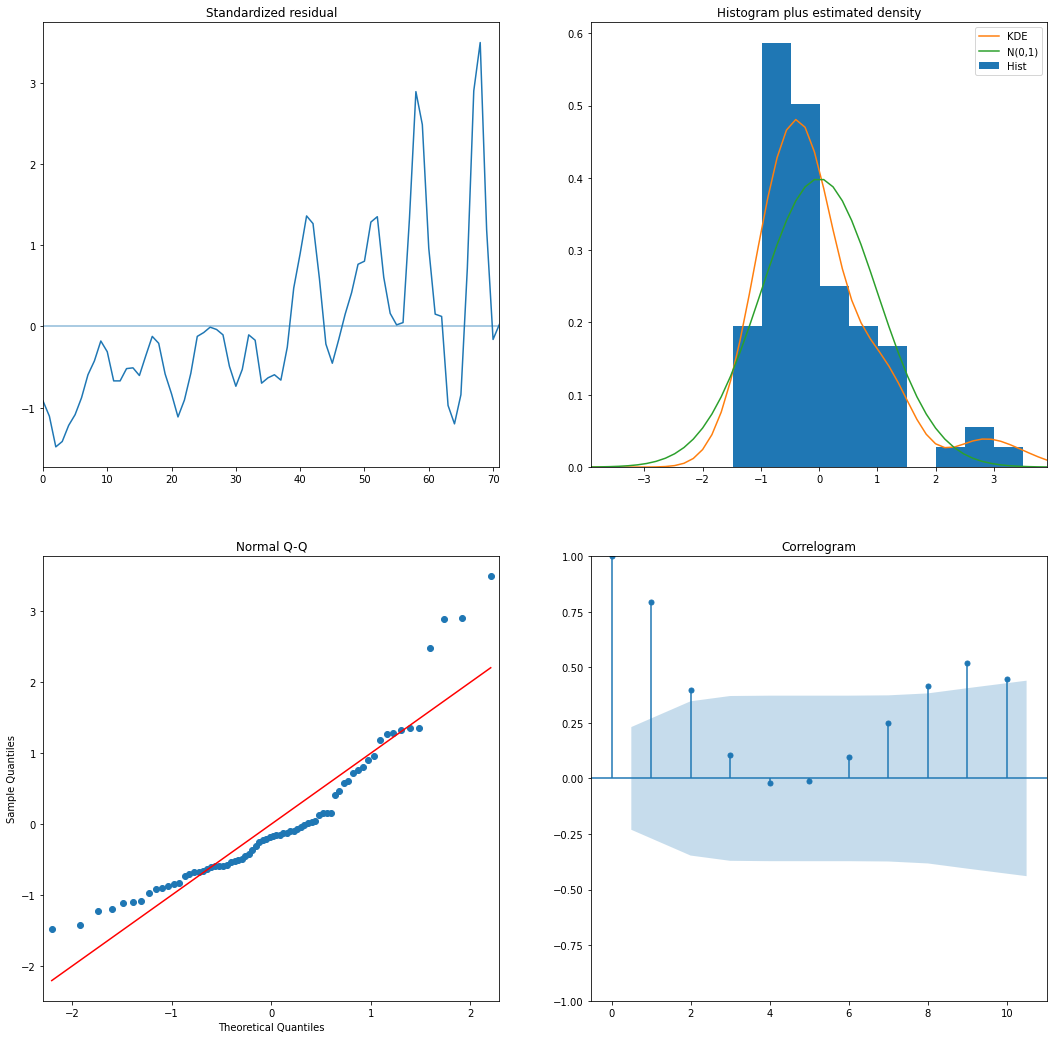

In [41]:
auto = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=5, max_q=5,
                     m=1,
                     max_d=2,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False,
                     enforce_stationarity=False, 
                     enforce_invertibility=False)

display(auto.summary())
display(auto.plot_diagnostics(figsize=(18,18)))

In [42]:
auto.order

(0, 1, 0)

In [43]:
auto.seasonal_order

(0, 0, 0, 0)

## Testing Our Auto Arima Model

In [44]:
auto_sarimax = SARIMAX(
    train,
    order=auto.order, seasonal_order = auto.seasonal_order).fit()
auto_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11216   No. Observations:                   73
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -792.682
Date:                Wed, 09 Mar 2022   AIC                           1587.365
Time:                        13:36:26   BIC                           1589.642
Sample:                    01-01-2010   HQIC                          1588.271
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       2.11e+08   2.58e+07      8.186      0.000     1.6e+08    2.61e+08
===================================================================================
Ljung-Box (L1) (Q):                  47.08   Jarque-Bera (JB):                38.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              22.80   Skew:                             1.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
test.index

DatetimeIndex(['2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='time', freq='MS')

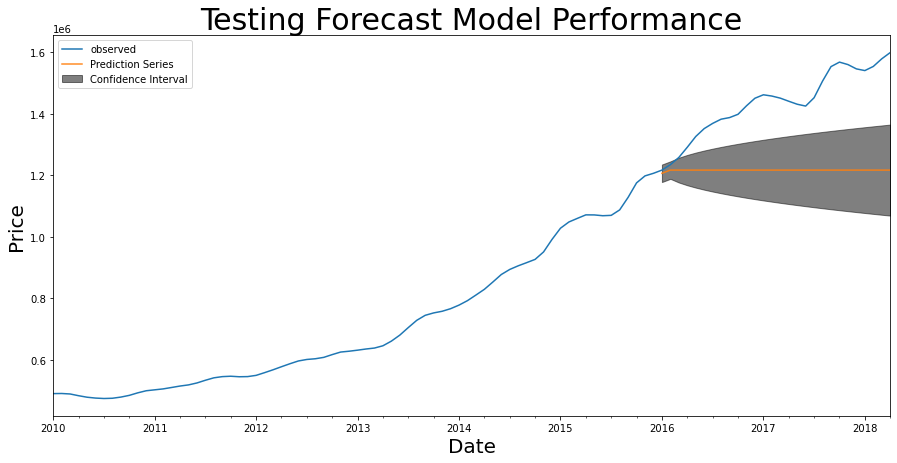

In [46]:
# Predictions for in and out of sampling forecast
pred = auto_sarimax.get_prediction(start=pd.to_datetime('2016-01-01'), 
          end=pd.to_datetime('2018-04-01'), dynamic = False)
pred_conf = pred.conf_int()

fig, ax = plt.subplots(figsize=(15, 7))

# Plot observed values
ax = ts_final[11216].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Prediction Series', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.5,label = 'Confidence Interval')

# Set axes labels
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Price',fontsize=20)
ax.set_title('Testing Forecast Model Performance',fontsize=30)
plt.legend()

plt.show()

In [47]:
# Getting a forecast for the next 36 months (3 years) after the last recorded date on our dataset.
forecast = auto_sarimax.get_forecast(36)
future_prediction = forecast.conf_int()
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 

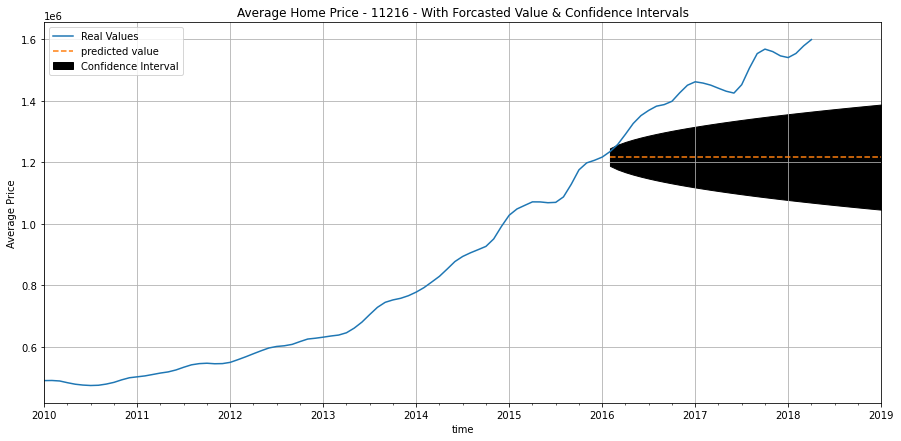

In [48]:
# Plotting our Forecast

fig, ax = plt.subplots(figsize=(15, 7))
ts_final[11216].plot(ax=ax,label='Real Values')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'],color='k',
                label='Confidence Interval')
ax.legend() 
plt.ylabel("Average Price")
plt.title('Average Home Price - 11216 - With Forcasted Value & Confidence Intervals')
plt.grid()
plt.show()

## Model Test 4

In [49]:
# Setting up parameter combinations.
# code from study group
p = d = q = (0, 2)

pdq = [(ar, diff, ma) for ar in p for diff in d for ma in q]
pdqs = [(c[0], c[1], c[2], 12) for c in pdq]

# Iterate and try models.
combo, value = (None, None)
for pdq_combo in pdq:
    for pdqs_combo in pdqs:
        model = SARIMAX(
            train, 
            order=pdq_combo,
            seasonal_order=pdqs_combo,
            enforce_stationarity=False,
            enforce_invertibility=False
            )
        output = model.fit()

        if value is None or output.aic < value:
            combo, value = ((pdq_combo, pdqs_combo), output.aic)
            print('SARIMA Combos:', (pdq_combo, pdqs_combo),'AIC:', output.aic)
                
            
print(f'\n{"*"*20}\nOptimal SARIMA order: {combo}')

SARIMA Combos: ((0, 0, 0), (0, 0, 0, 12)) AIC: 2155.799897756573
SARIMA Combos: ((0, 0, 0), (0, 2, 0, 12)) AIC: 1195.4089097646597
SARIMA Combos: ((0, 0, 0), (0, 2, 2, 12)) AIC: 588.461713644316
SARIMA Combos: ((0, 0, 0), (2, 2, 2, 12)) AIC: 576.1727138910064
SARIMA Combos: ((0, 0, 2), (0, 2, 2, 12)) AIC: 529.9006128121522
SARIMA Combos: ((0, 2, 0), (0, 2, 2, 12)) AIC: 499.25607377037784
SARIMA Combos: ((0, 2, 0), (2, 2, 2, 12)) AIC: 492.3506373536708
SARIMA Combos: ((0, 2, 2), (0, 2, 2, 12)) AIC: 448.0646131825706
SARIMA Combos: ((2, 2, 2), (0, 2, 2, 12)) AIC: 435.3264048427279

********************
Optimal SARIMA order: ((2, 2, 2), (0, 2, 2, 12))


In [50]:
sarimax1 = SARIMAX(
    train,
    order=(2,2,2),
    seasonality_order=(0,2,2,12),
    enforce_stationarity=False,
    enforce_invertibility=False, 
    trace=True).fit()
sarimax1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11216   No. Observations:                   73
Model:               SARIMAX(2, 2, 2)   Log Likelihood                -673.963
Date:                Wed, 09 Mar 2022   AIC                           1357.926
Time:                        13:36:55   BIC                           1369.023
Sample:                    01-01-2010   HQIC                          1362.323
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7843      0.112      7.016      0.000       0.565       1.003
ar.L2         -0.6566      0.060    -10.911      0.000      -0.775      -0.539
ma.L1         -0.0534      0.153     -0.349      0.727      -0.353       0.246
ma.L2         -0.0022      0.061     -0.036      0.972      -0.121       0.117
sigma2      2.052e+07   5.63e-09   3.65e+15      0.000    2.05e+07    2.05e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                26.52
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              13.37   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+31. Standard errors may be unstable.
"""

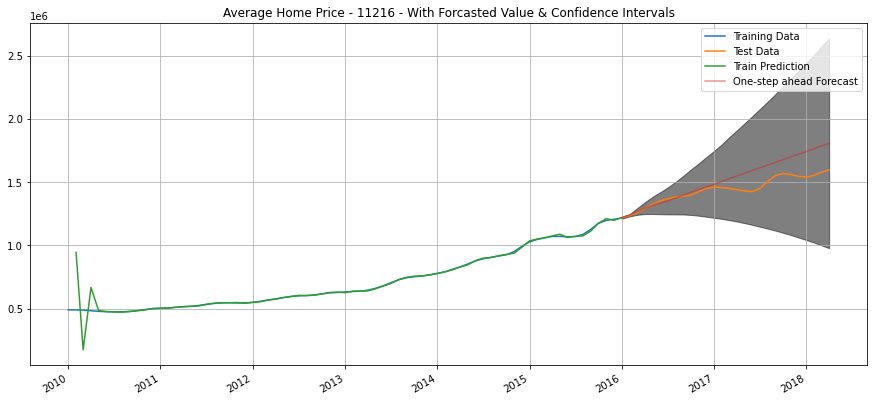

In [72]:
pred = sarimax1.get_prediction(start=test.index.min(), 
          end=test.index.max(), dynamic = False)
pred_conf = pred.conf_int()

fig, ax = plt.subplots(figsize=(15, 7))

plt.plot(train, label = 'Training Data')
plt.plot(test, label = 'Test Data')
plt.plot(sarimax1.predict(start=train.index.min(), 
          end=train.index.max())[1:], label = 'Train Prediction')
# plt.plot(auto_arima.predict(start=test.index.min(), 
#           end=test.index.max()), label = 'Test Prediction')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.5)
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.5)
plt.title('Average Home Price - 11216 - With Forcasted Value & Confidence Intervals')
plt.grid()
plt.legend()

In [75]:
# forecast = sarimax1.predict(n_periods=len(test))
# forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])
# print('Test RMSE: ', mean_squared_error(test, forecast)**0.5)

# Forecasting the Future

In [52]:
sarimax_all = SARIMAX(
    ts_final[11216],
    order=(2,2,2),
    seasonality_order=(0,2,2,12),
    enforce_stationarity=True,
    enforce_invertibility=False, 
    trace=True).fit()
sarimax_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  11216   No. Observations:                  100
Model:               SARIMAX(2, 2, 2)   Log Likelihood               -1026.555
Date:                Wed, 09 Mar 2022   AIC                           2063.111
Time:                        13:36:55   BIC                           2076.036
Sample:                    01-01-2010   HQIC                          2068.339
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4778      0.199      7.418      0.000       1.087       1.868
ar.L2         -0.5877      0.150     -3.920      0.000      -0.881      -0.294
ma.L1         -2.5029      0.214    -11.706      0.000      -2.922      -2.084
ma.L2          1.5023      0.483      3.111      0.002       0.556       2.449
sigma2      3.218e+07   1.95e-08   1.65e+15      0.000    3.22e+07    3.22e+07
===================================================================================
Ljung-Box (L1) (Q):                  25.44   Jarque-Bera (JB):                25.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.58   Skew:                             0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.56e+30. Standard errors may be unstable.
"""

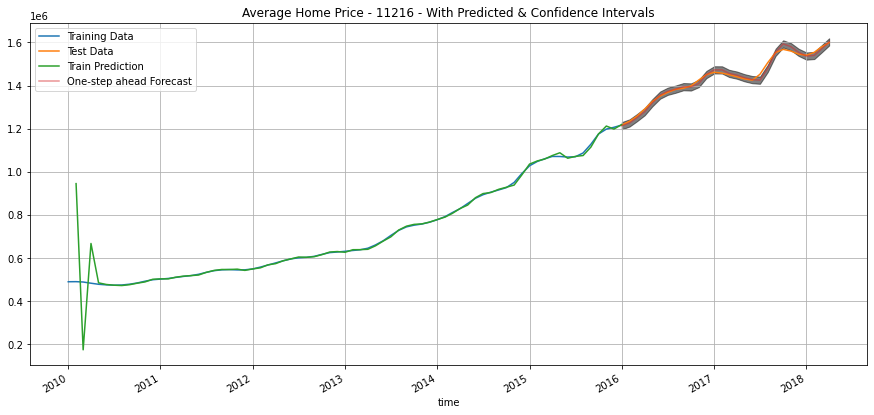

In [53]:
pred = sarimax_all.get_prediction(start=test.index.min(), 
          end=test.index.max(), dynamic = False)
pred_conf = pred.conf_int()

fig, ax = plt.subplots(figsize=(15, 7))

plt.plot(train, label = 'Training Data')
plt.plot(test, label = 'Test Data')
plt.plot(sarimax1.predict(start=train.index.min(), 
          end=train.index.max())[1:], label = 'Train Prediction')
# plt.plot(auto_arima.predict(start=test.index.min(), 
#           end=test.index.max()), label = 'Test Prediction')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.5)
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.5)
plt.title('Average Home Price - 11216 - With Predicted & Confidence Intervals')
plt.grid()
plt.legend()

In [54]:
# Getting a forecast for the next 36 months (3 years) after the last recorded date on our dataset.
forecast = sarimax_all.get_forecast(36)
future_prediction = forecast.conf_int()
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 

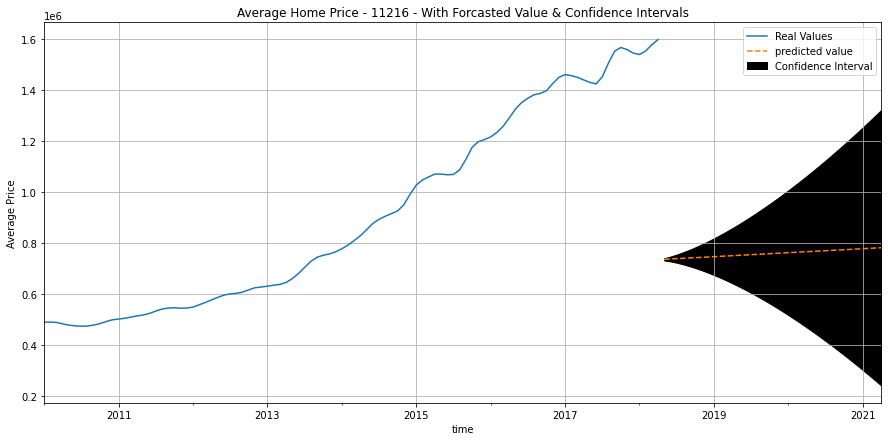

In [79]:
# Plotting our Forecast

fig, ax = plt.subplots(figsize=(15, 7))
ts_final[11216].plot(ax=ax,label='Real Values')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'],color='k',
                label='Confidence Interval')
ax.legend() 
plt.ylabel("Average Price")
plt.title('Average Home Price - 11216 - With Forcasted Value & Confidence Intervals')
plt.grid()
plt.show()

# All Zip Codes

In [56]:
top_roi = ts_final.loc[:,[11216, 11222, 11221, 11233, 11211, 11238, 11217, 11106, 11102, 11368]]
top_roi

,11216,11222,11221,11233,11211,11238,11217,11106,11102,11368
time,,,,,,,,,,
2010-01-01,490200.0,608500.0,410300.0,367800.0,615600.0,1196100.0,1544500.0,520200.0,547000.0,435300.0
2010-02-01,490600.0,610000.0,411900.0,364100.0,614200.0,1193400.0,1548800.0,519800.0,544800.0,435400.0
2010-03-01,489000.0,599200.0,408500.0,358000.0,608900.0,1183700.0,1547100.0,516500.0,535800.0,433500.0
2010-04-01,483400.0,581600.0,398000.0,348000.0,594700.0,1177800.0,1534700.0,510400.0,514300.0,434900.0
2010-05-01,478500.0,577400.0,391800.0,339400.0,587000.0,1168400.0,1531000.0,507100.0,495800.0,435600.0
...,...,...,...,...,...,...,...,...,...,...
2017-12-01,1545700.0,1651200.0,998100.0,809800.0,1463100.0,2768900.0,3404100.0,1043900.0,1053700.0,720700.0
2018-01-01,1540200.0,1661800.0,1000900.0,800800.0,1496100.0,2810700.0,3413800.0,1067100.0,1071500.0,727100.0
2018-02-01,1553600.0,1672800.0,1015400.0,806100.0,1531100.0,2848100.0,3482900.0,1079200.0,1072700.0,731400.0


In [57]:
SPLIT = '2016-01-01'

# Train-test-split all zipcodes
for zipcode in top_roi.columns:
    train = top_roi[zipcode][:SPLIT]
    test = top_roi[zipcode][SPLIT:]
    

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1587.365, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=1734.029, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12]             : AIC=1592.287, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=1590.006, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=1599.563, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=1737.683, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=1591.992, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1542.826, Time=0.00 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1544.549, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1544.519, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1546.505, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1561.154, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] inte

<function pmdarima.arima.arima.ARIMA.summary(self)>

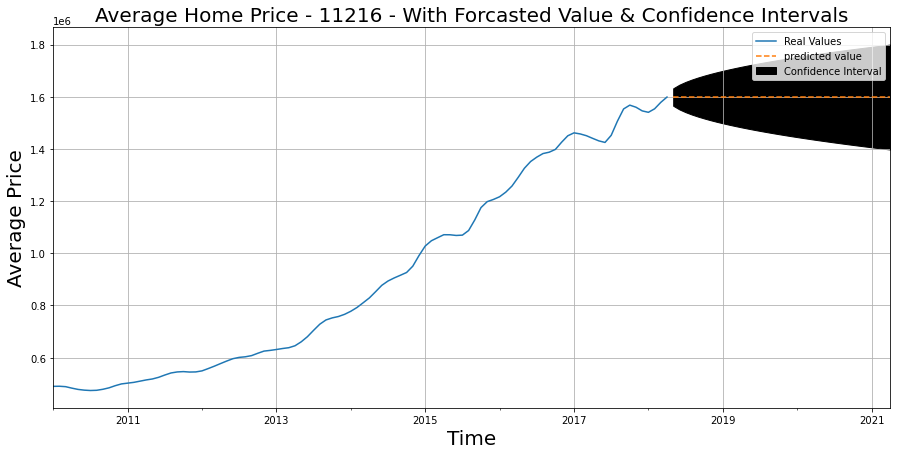

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1509.349, Time=0.00 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1509.716, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1512.694, Time=0.10 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1510.974, Time=0.06 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1513.527, Time=0.02 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1512.264, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1508.954, Time=0.01 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=1509.729, Time=0.03 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=1509.506, Time=0.10 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=1517.875, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1514.152, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1512.195, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=1511.794, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[12] intercept   : AIC=1510.872, Time=0.02 sec

Best model:  ARIMA

<function pmdarima.arima.arima.ARIMA.summary(self)>

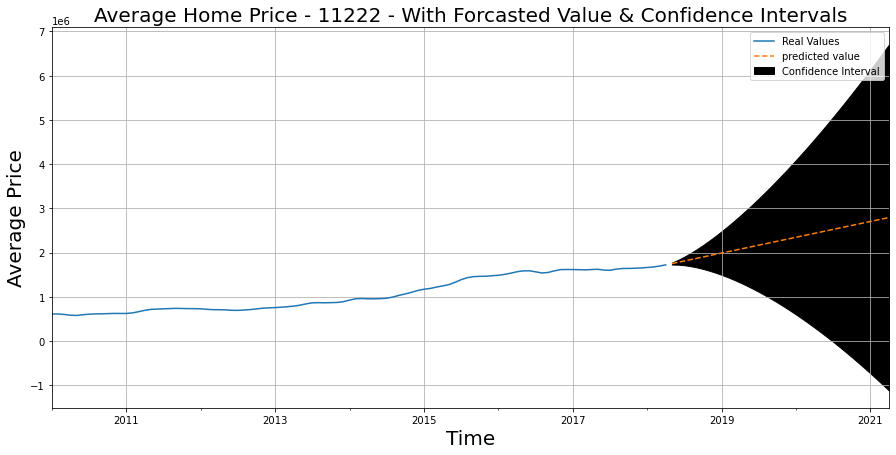

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1353.142, Time=0.00 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1354.179, Time=0.02 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1357.385, Time=0.04 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1355.214, Time=0.01 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1359.208, Time=0.04 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1361.135, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1352.284, Time=0.01 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=1354.179, Time=0.02 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=1356.177, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=1356.282, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1355.889, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1352.240, Time=0.03 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1357.384, Time=0.04 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1359.381, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0

<function pmdarima.arima.arima.ARIMA.summary(self)>

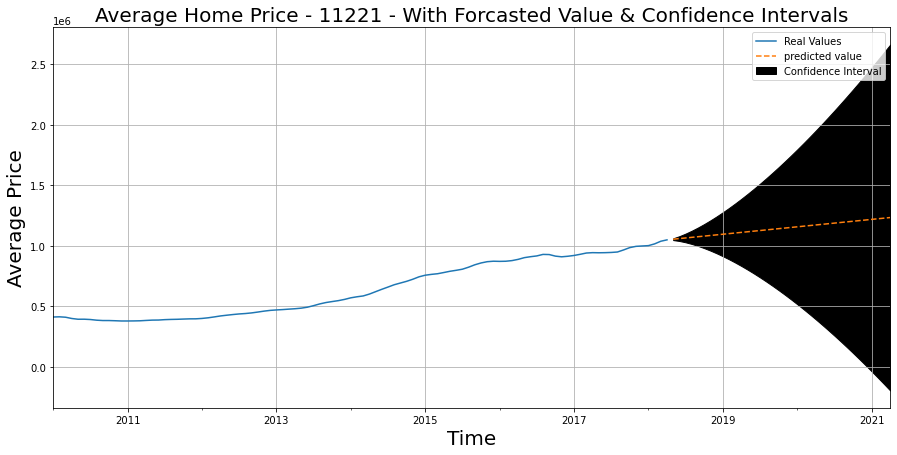

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1491.505, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=1494.889, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12]             : AIC=1505.325, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=1494.341, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=1500.514, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=1594.195, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=1503.332, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=1651.251, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1470.399, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1471.545, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1471.538, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1473.538, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1479.349, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12]

<function pmdarima.arima.arima.ARIMA.summary(self)>

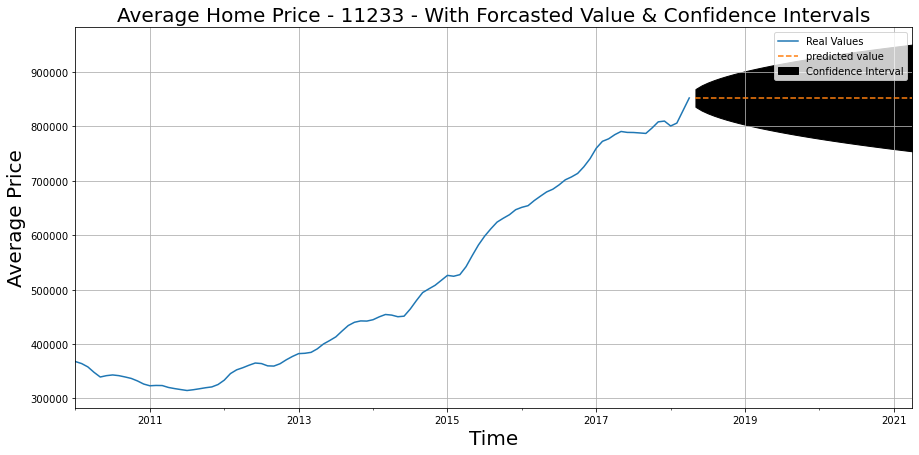

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1504.709, Time=0.00 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1508.336, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1510.330, Time=0.02 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1507.188, Time=0.05 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1513.705, Time=0.02 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1512.604, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1506.398, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1508.400, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1510.240, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1506.550, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.210 seconds


<function pmdarima.arima.arima.ARIMA.summary(self)>

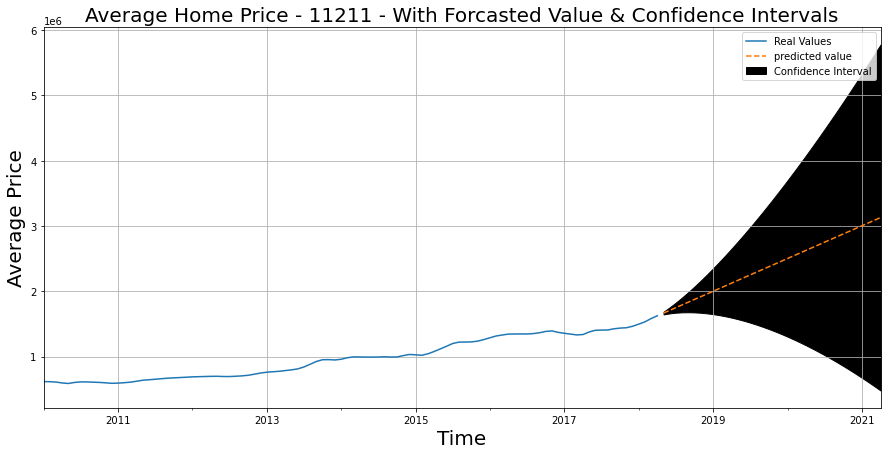

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1514.759, Time=0.00 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1516.609, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1516.561, Time=0.02 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1515.359, Time=0.01 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1515.339, Time=0.01 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1515.937, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1516.201, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1516.194, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1517.714, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1516.662, Time=0.00 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.293 seconds


<function pmdarima.arima.arima.ARIMA.summary(self)>

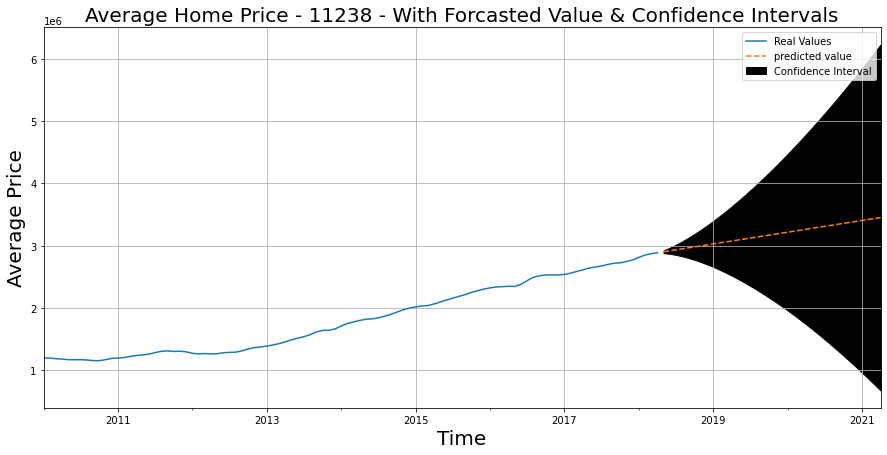

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1523.084, Time=0.00 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1525.923, Time=0.02 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1526.881, Time=0.03 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1525.256, Time=0.02 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1527.200, Time=0.04 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1529.206, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1524.658, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1525.737, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1528.630, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1524.901, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.191 seconds


<function pmdarima.arima.arima.ARIMA.summary(self)>

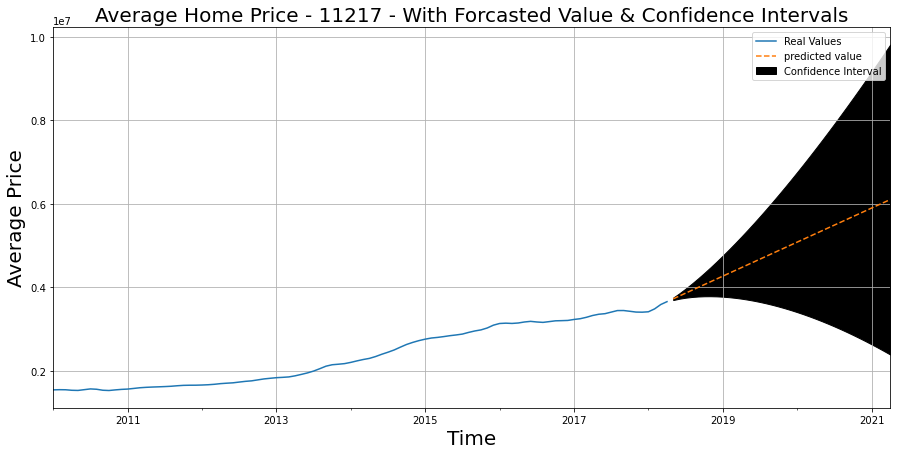

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1368.250, Time=0.00 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1371.487, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1371.524, Time=0.04 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1371.216, Time=0.03 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1371.828, Time=0.03 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1372.893, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1369.506, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1369.543, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1371.477, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1370.080, Time=0.00 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.233 seconds


<function pmdarima.arima.arima.ARIMA.summary(self)>

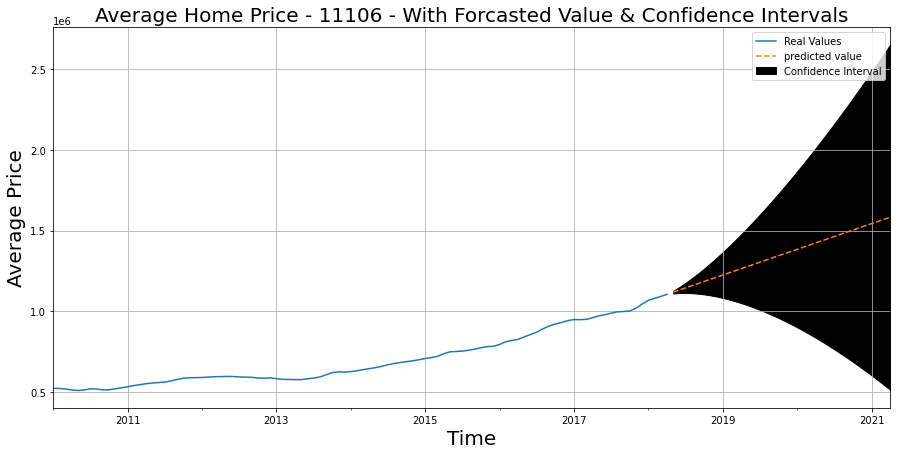

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1484.236, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=1534.390, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12]             : AIC=1513.836, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=1488.137, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12]             : AIC=1485.409, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=1486.034, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=1513.628, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=1614.779, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1464.172, Time=0.00 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1466.117, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1466.115, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1468.113, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1515.288, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12]

<function pmdarima.arima.arima.ARIMA.summary(self)>

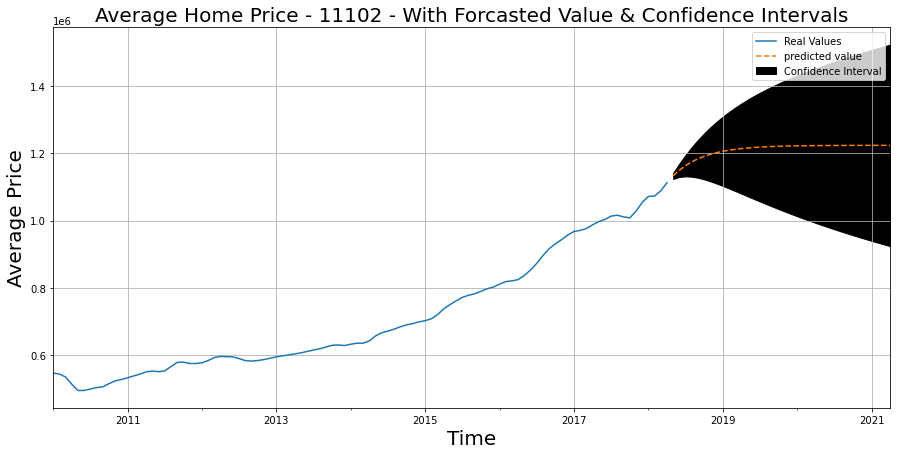

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1306.266, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1309.243, Time=0.02 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1309.239, Time=0.02 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1309.803, Time=0.01 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1319.510, Time=0.03 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1307.416, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1307.420, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1308.193, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1308.200, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.345 seconds


<function pmdarima.arima.arima.ARIMA.summary(self)>

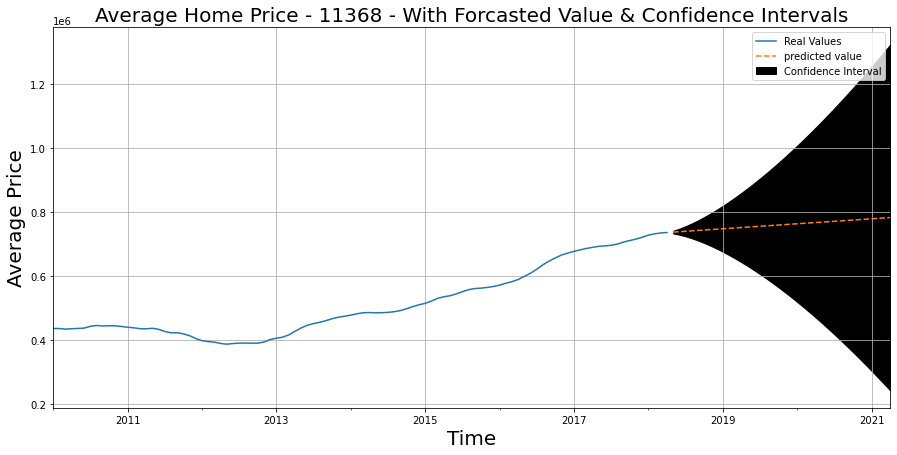

In [81]:
SPLIT = '2016-01-01'

zip_future = {}

# Train-test-split all zipcodes
for zipcode in top_roi.columns:
    train = top_roi[zipcode][:SPLIT]
    test = top_roi[zipcode][SPLIT:]
    
    auto_all = pm.auto_arima(train, start_p=0, start_q=0,
                             test='adf',
                             max_p=5, max_q=5,
                             m=12,
                             max_d=2,
                             seasonal = True,
                             start_P=0,start_Q=0,
                             D=0,
                             trace=True,
                             error_action= 'ignore',
                             suppress_warnings=True,
                             stepwise=True,with_intercept=False,
                             enforce_stationarity=False, 
                             enforce_invertibility=False)

    display(auto.summary)
#     display(auto.plot_diagnostics(figsize=(18,18)))
    
    # Forecasting future with all of the data    
    sarimax_all = SARIMAX(
    top_roi[zipcode],
    order = auto_all.order,
    seasonal_order= auto_all.seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False, 
    trace=True).fit()
    
    fig, ax = plt.subplots(figsize=(15, 7))
    ts_final[zipcode].plot(ax=ax,label='Real Values')
    
    forecast = sarimax_all.get_forecast(36)
    future_prediction = forecast.conf_int()
    future_prediction['value'] = forecast.predicted_mean
    future_prediction.columns = ['lower','upper','prediction'] 


    future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

    ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'],color='k',
                label='Confidence Interval')
    ax.legend() 
    plt.ylabel("Average Price", fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.title(f'Average Home Price - {zipcode} - With Forcasted Value & Confidence Intervals', fontsize=20)
    plt.grid()
    plt.show()
    
#     print('Test RMSE: ', mean_squared_error(test, forecast[zipcode])**0.5)

# Recommendations 

Top Zipcodes that show promising forecasting:

Brooklyn:
 
- 11222
- 11217
- 11211

Queens:
- 11106
- 11102
